# Trabalho Prático 1 - ICV

### Inicialização

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg

### Imagem Original

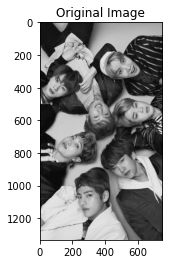

In [2]:
img = cv2.imread('bts.jpg',0)
plt.title('Original Image')
plt.imshow(img, cmap = 'gray')
plt.show()

### Compressão Psicovisual

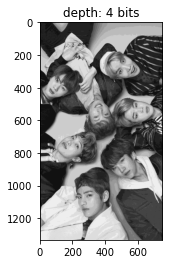

In [3]:
# 4 bits
img_c = img & 0xf0
plt.title('depth: 4 bits')
plt.imshow(img_c, cmap = 'gray')
plt.show()

### DCT

In [ ]:
def remove_below_2nd_diag(image):
    return np.rot90(np.tril(np.rot90(image)), 3)

# extração da DCT para a imagem
img_c = img_c.astype(float)
img_c = img_c-128
step = 8

size = img_c.shape
DCT = np.zeros(size, dtype=np.float)

for y in range(0,size[0],step):
    for x in range(0,size[1],step):
        
        dct = fftpack.dct(fftpack.dct(img_c[y:y+step, x:x+step].T, norm='ortho').T, norm='ortho')
        
        first = dct[0, 0]
        
        dct = remove_below_2nd_diag(dct)
        
        DCT[y:y+step, x:x+step] = dct

plt.subplot(121),plt.imshow(DCT, cmap = 'gray', clim=(0, 255))
plt.title('DCT image'), plt.xticks([]), plt.yticks([])
plt.show()

# file with the DCT output
mpimg.imsave("dct.png", DCT, 0, 255, cmap='gray')

### IDCT

In [ ]:
IDCT = np.zeros(size, dtype=np.float)

for y in range(0,size[0],step):
    for x in range(0,size[1],step):
                
        idct = fftpack.idct(fftpack.idct(DCT[y:y+step, x:x+step].T, norm='ortho').T, norm='ortho')

        IDCT[y:y+step, x:x+step] = idct

img_c = img_c+128  
IDCT = IDCT+128

plt.subplot(121),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

# file with the inverse of DCT
mpimg.imsave("idct.png", IDCT, 0, 255, cmap='gray')

### Huffman

In [4]:
# image entropy
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

print(img_c)

[[ 32  32  32 ... 160 160 160]
 [ 32  32  32 ... 160 160 160]
 [ 32  32  32 ... 160 160 160]
 ...
 [224 224 224 ...  48  48  48]
 [224 224 224 ...  48  48  48]
 [224 224 224 ...  48  48  48]]


In [5]:
# huffman
from heapq import heappush, heappop, heapify
from collections import defaultdict

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = []
    for sym, wt in symb2freq.items():
        if (wt > 0):
            heap.append([wt, [sym, ""]])
    
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

In [11]:
height, width =  img_c.shape
entimg1 = calcEntropy(img_c)

# compute histogram
img_c = img_c.astype(float)
hist = cv2.calcHist([img_c],[0],None,[256],[0,256])
hist = hist.ravel()/hist.sum()

symb2freq = defaultdict(float)
for i in range(0,256):
    symb2freq[i] = hist[i]

# enconde
huff = encode(symb2freq)

print ("Symbol\tWeight\t\tHuffman Code")
for p in huff:
   if (symb2freq[p[0]] > 0):
        print ("%d\t%f\t%s" % (p[0], symb2freq[p[0]], p[1]))
    
nbits = 0
for i in range(0,256):
    nbits += len(huff[i][1]) * hist[huff[i][0]] * height * width
    
# bits per pixel
bpp = nbits / (height * width)
    
print ("Compression ratio (without header): %5.3f" % (8/bpp))

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\histogram.cpp:919: error: (-210:Unsupported format or combination of formats)  in function 'cv::calcHist'


In [ ]:
img_huff = ''

for x in range(height):
    for y in range(width):
        for p in huff:
            if p[0] == img_c[x,y]:
                print(p[1])
                img_huff += p[1]
        #print(huff[img_c[x,y]][1])
        
print(img_huff)